# AIPI 590 - XAI | Assignment #01
### Interpretable ML
### Ailina Aniwan

#### https://colab.research.google.com/github/ailina-aniwan/xai-interpretable-ml/blob/main/telco_churn_analysis.ipynb
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ailina-aniwan/xai-interpretable-ml/blob/main/telco_churn_analysis.ipynb)


In [1]:
# Basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, mean_squared_error, r2_score

# GAM
!pip install pygam --quiet
from pygam import LogisticGAM, s


[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## 1. Exploratory Data Analysis & Assumptions
### Load Data & Data Overview

In [2]:
# Load the dataset
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

# Quick look
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Inspect Data Structure & Clean Columns

In [3]:
# Inspect dataset info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Missing value check
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [5]:
# Convert TotalCharges to numeric (fix non-numeric entries)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing values
df = df.dropna()
print("\nShape after cleaning:", df.shape)


Shape after cleaning: (7032, 21)


In [6]:
# Summary statistics
display(df.describe())

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [7]:
# Target distribution
churn_counts = df['Churn'].value_counts()
churn_percent = df['Churn'].value_counts(normalize=True) * 100

print("\nChurn counts:\n", churn_counts)
print("\nChurn percentages:\n", churn_percent.round(2))


Churn counts:
 Churn
No     5163
Yes    1869
Name: count, dtype: int64

Churn percentages:
 Churn
No     73.42
Yes    26.58
Name: proportion, dtype: float64


**Summary**:
- The dataset initially contained 7043 rows × 21 columns. Most features are categorical such as `Contract`, `InternetService`, `PaymentMethod`, etc, with a few numeric variables like `tenure`, `MonthlyCharges`, and `TotalCharges`.  
- The `TotalCharges` column contained non-numeric values stored as strings; after converting to numeric and dropping invalid rows, the cleaned dataset has 7,032 rows. A missing value check confirmed no remaining nulls. 
- About 26.6% of customers churned vs 73.4% who stayed, which shows a moderately imbalanced dataset.  
- These checks confirm the dataset is clean and ready for exploratory analysis.  


### Visualization Plots

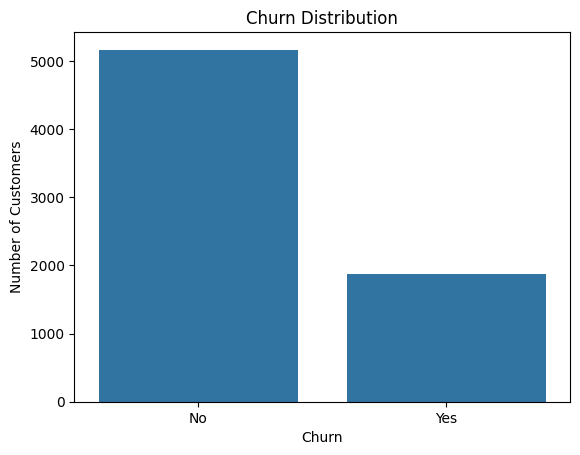

In [8]:
# Distribution of Churn
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Number of Customers")
plt.show()


> The dataset is imbalanced, with about 73% of customers not churning and 27% churning. This imbalance is important for modeling because it may bias simple linear models toward predicting the majority class. Logistic regression can still perform well with proper weighting or resampling, while GAM can flexibly capture patterns but also needs to account for class imbalance.


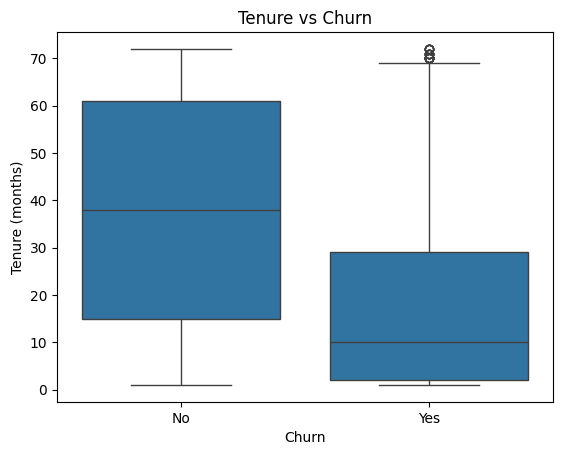

In [9]:
# Tenure vs Churn
sns.boxplot(x="Churn", y="tenure", data=df)
plt.title("Tenure vs Churn")
plt.xlabel("Churn")
plt.ylabel("Tenure (months)")
plt.show()

> Customers with shorter tenure are far more likely to churn compared to those with longer tenure. The median tenure for churned customers is less than one year, while non-churned customers tend to stay much longer. This pattern means a non-linear relationship, which may not be fully captured by linear models but can be better modeled with logistic regression or GAM.


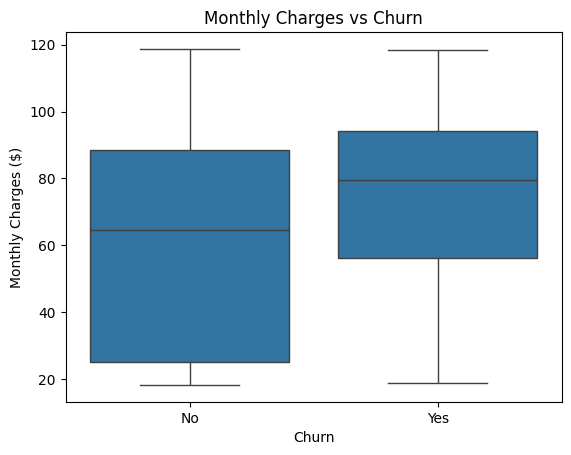

In [10]:
# Monthly Charges vs Churn
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("Monthly Charges vs Churn")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges ($)")
plt.show()

> Churned customers generally face higher monthly charges than those who stay, with a visibly higher median and narrower spread. This shows a positive association between higher costs and likelihood of churn. The trend appears roughly monotonic, which supports logistic regression but also leaves room for more flexible GAM models to capture potential non-linearities.


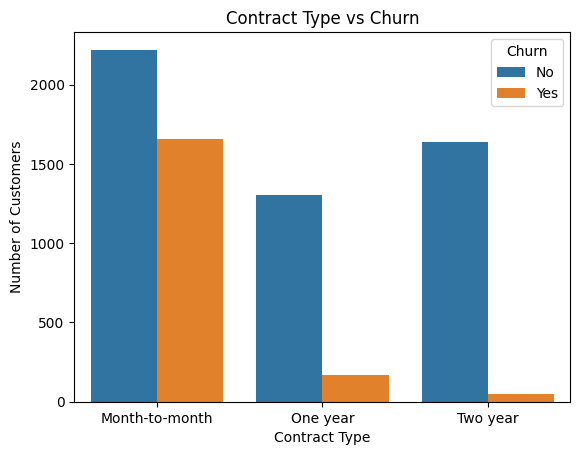

In [11]:
# Categorical Contract vs Churn
sns.countplot(x="Contract", hue="Churn", data=df)
plt.title("Contract Type vs Churn")
plt.xlabel("Contract Type")
plt.ylabel("Number of Customers")
plt.legend(title="Churn")
plt.show()

> Month-to-month contracts have the highest churn rate, while churn is rare among one-year and two-year contracts. This shows a strong categorical effect of contract type on churn. Since this predictor is nominal, it will be represented with dummy variables in linear/logistic regression, and both logistic regression and GAM are capable of handling such categorical predictors effectively.


### Correlation Check

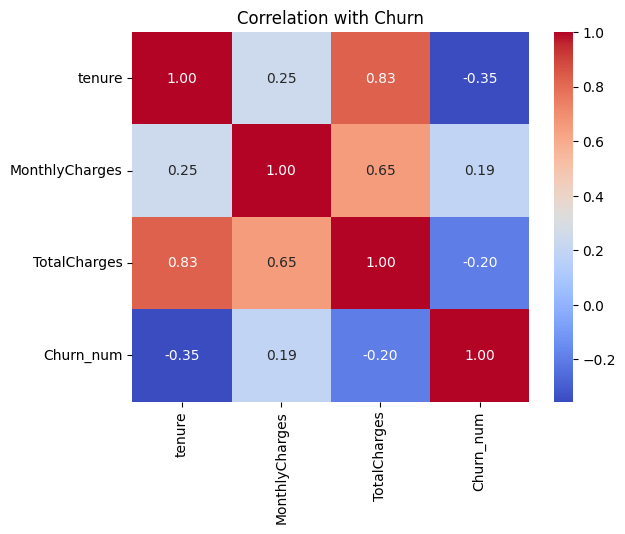

In [12]:
# Correlation heatmap
df['Churn_num'] = df['Churn'].map({'Yes': 1, 'No': 0})
numeric_corr = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_num']].corr()

sns.heatmap(numeric_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation with Churn")
plt.show()



> The above correlation heatmap was generated to evaluate linear relationships between numeric features and churn. As expected, tenure and TotalCharges are highly correlated, which means that longer-tenured customers accumulate higher overall charges MonthlyCharges also shows a moderate correlation with TotalCharges.  

> In terms of the target, churn is moderately negatively correlated with tenure (–0.35), therefore customers with shorter tenures are more likely to leave. Churn has a weaker positive correlation with MonthlyCharges (0.19) that higher monthly bills may contribute slightly to churn.   


> All above findings suggest that a purely linear model may underfit some relationships, logistic regression is more appropriate for binary classification, and GAMs may better capture the nonlinear but smooth effects of tenure and charges.  

## 2. Linear Regression
### Prepare the Data

In [13]:
# Features
X = df[['tenure', 'MonthlyCharges', 'TotalCharges']]
y = df['Churn_num']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


### Fit Linear Regression

In [14]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions
y_pred = linreg.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Intercept:", linreg.intercept_)
print("Coefficients:", linreg.coef_)
print("MSE:", round(mse, 4))
print("R^2:", round(r2, 4))

Intercept: 0.06171669285331133
Coefficients: [-2.70401206e-03  7.16986193e-03 -7.55002186e-05]
MSE: 0.1519
R^2: 0.2218


### Interpret Coefficients

In [15]:
# Organize coefficients into a dataframe
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linreg.coef_
}).sort_values(by="Coefficient", ascending=False)

coef_df


,Feature,Coefficient
1,MonthlyCharges,0.007170
2,TotalCharges,-0.000076
0,tenure,-0.002704


### Visualize Coefficients

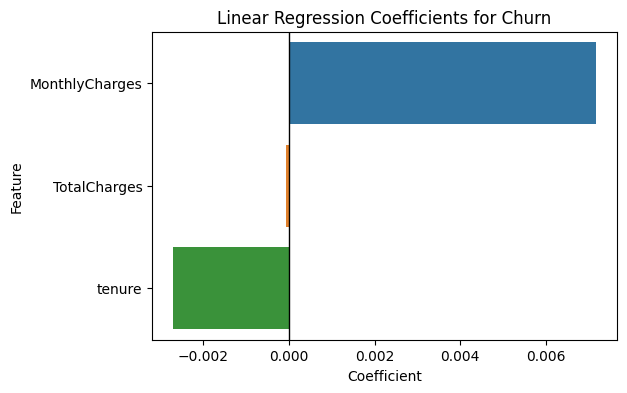

In [16]:
plt.figure(figsize=(6,4))
sns.barplot(x="Coefficient", y="Feature", hue="Feature", data=coef_df)
plt.title("Linear Regression Coefficients for Churn")
plt.axvline(0, color="black", linewidth=1)
plt.show()

> Monthly Charges (+0.0072): Higher monthly charges are associated with an increase in churn likelihood that each extra dollar raises the predicted churn probability slightly.

> Total Charges (–0.000076): Higher cumulative charges are associated with a slight decrease in churn, which means that customers who have paid more over time are generally retained longer.

>Tenure (–0.0027): Longer tenure reduces churn likelihood that each extra month decreases predicted churn probability slightly.

### Residual Analysis

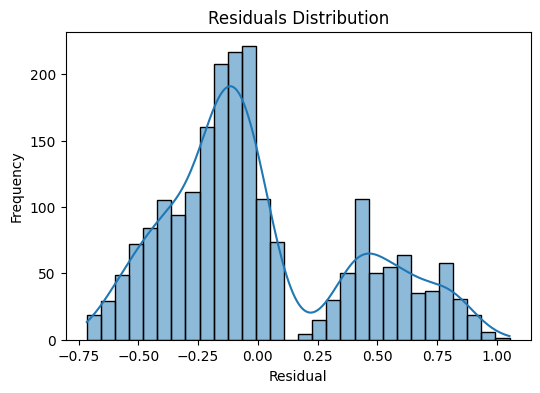

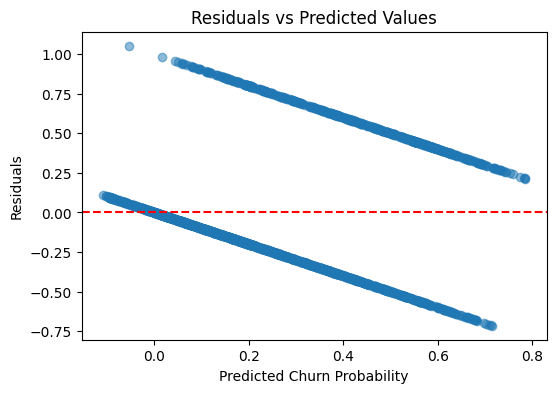

In [17]:
# Residuals
residuals = y_test - y_pred

# Histogram of residuals
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Churn Probability")
plt.ylabel("Residuals")
plt.show()

> Residuals Distribution: The residuals are not normally distributed and instead cluster around two groups. This happens because churn is binary (0/1), and linear regression cannot fully capture that structure.

> Residuals vs. Predicted: The clear banding pattern shows systematic errors that residuals vary with predicted churn values. This violates the constant variance assumption of linear regression.

> These plots show that linear regression is not appropriate for binary classification, and we should move to logistic regression.

## 3. Logistic Regression
### Fit Logistic Regression

In [18]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Performance metrics
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Intercept:", logreg.intercept_)
print("Coefficients:", logreg.coef_)
print("Accuracy:", round(acc, 4))
print("ROC AUC:", round(roc_auc, 4))
print("\nClassification Report:\n", report)


Intercept: [-1.62588125]
Coefficients: [[-0.06845084  0.03055547  0.00016234]]
Accuracy: 0.7758
ROC AUC: 0.6643

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.86      1549
           1       0.61      0.43      0.50       561

    accuracy                           0.78      2110
   macro avg       0.71      0.66      0.68      2110
weighted avg       0.76      0.78      0.76      2110



> The logistic regression model achieves about 77.6% accuracy with a ROC AUC of 0.66 and shows moderate ability to separate churners from non-churners. The model performs well on non-churn customers (precision 0.81, recall 0.90) but struggles on churners (precision 0.61, recall 0.43), which is expected given the class imbalance. Accuracy looks fairly strong, but ROC AUC and recall show the model misses many true churn cases.

### Interpret Coefficients

In [19]:
# Organize coefficients
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": logreg.coef_[0]
})
coef_df["Odds Ratio"] = np.exp(coef_df["Coefficient"])
display(coef_df)

,Feature,Coefficient,Odds Ratio
0,tenure,-0.068451,0.933839
1,MonthlyCharges,0.030555,1.031027
2,TotalCharges,0.000162,1.000162


> Tenure has a negative coefficient (OR ≈ 0.93) which means that each additional month reduces churn odds by about 6–7%. MonthlyCharges is positive (OR ≈ 1.03), so higher bills increase churn risk, with each extra dollar raising odds by ~3%. TotalCharges is mostly neutral (OR ≈ 1.00), likely because it overlaps with tenure and charges.

### Visualize Coefficients

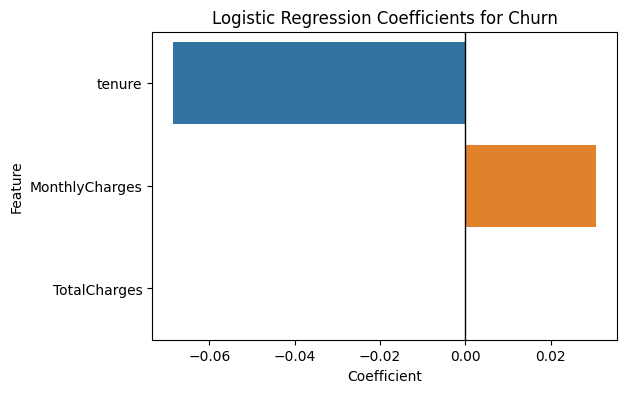

In [20]:
plt.figure(figsize=(6,4))
sns.barplot(x="Coefficient", y="Feature", hue="Feature", data=coef_df)
plt.title("Logistic Regression Coefficients for Churn")
plt.axvline(0, color="black", linewidth=1)
plt.show()

> The barplot confirms that tenure strongly decreases churn risk, while MonthlyCharges slightly increases it. TotalCharges shows no real effect. The visualization makes the direction and relative strength of these relationships easy to interpret.

## 4. Generalized Additive Model (GAM)
### Fit GAM

In [21]:
gam = LogisticGAM( s(0) + s(1) + s(2) ).gridsearch(
    X_train.values, y_train.values,
    lam = np.logspace(-4, 3, 8)
)

# Predict
proba_gam = gam.predict_proba(X_test.values)
y_pred_gam = (proba_gam >= 0.5).astype(int)

# Evaluate
acc_gam = accuracy_score(y_test, y_pred_gam)
auc_gam = roc_auc_score(y_test, proba_gam)
report_gam = classification_report(y_test, y_pred_gam)

print("GAM summary (truncated):")
print(gam.statistics_['pseudo_r2'])
print("\nAccuracy:", round(acc_gam, 4))
print("ROC AUC:", round(auc_gam, 4))
print("\nClassification Report:\n", report_gam)


  0% (0 of 8) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 12% (1 of 8) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:01
 25% (2 of 8) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 37% (3 of 8) |#########                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (4 of 8) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 62% (5 of 8) |################          | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (6 of 8) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 87% (7 of 8) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (8 of 8) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


GAM summary (truncated):
OrderedDict({'explained_deviance': 0.25095620139257335, 'McFadden': 0.7490437986074265, 'McFadden_adj': 0.2433375333426251})

Accuracy: 0.7858
ROC AUC: 0.8152

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1549
           1       0.64      0.44      0.52       561

    accuracy                           0.79      2110
   macro avg       0.73      0.67      0.69      2110
weighted avg       0.77      0.79      0.77      2110



> The GAM achieved an accuracy of 0.79 and a ROC AUC of 0.82 and improved slightly over logistic regression. The model also produced balanced precision and recall for the majority class, though recall for churners remained modest. The deviance explained (~25%) means that while the GAM captures meaningful structure in the data, there is still room for unexplained variation. Therefore, GAM offers better predictive power than logistic regression by accounting for non-linearities, but the challenge of identifying churners (class 1) persists.

### Partial Dependence Plots

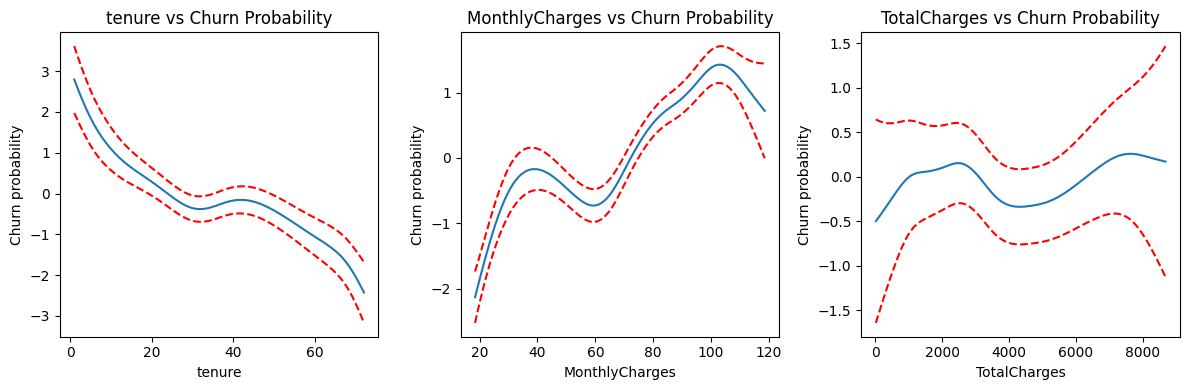

In [22]:
# Plot partial dependence for each feature
plt.figure(figsize=(12, 4))
for i, feature in enumerate(['tenure', 'MonthlyCharges', 'TotalCharges']):
    plt.subplot(1, 3, i + 1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    plt.title(f"{feature} vs Churn Probability")
    plt.xlabel(feature)
    plt.ylabel("Churn probability")

plt.tight_layout()
plt.show()


> The smooth plots show clear non-linear relationships between customer features and churn probability. Tenure shows a steep drop in churn risk during the first months, with the curve flattening as customers remain longer, and shows the importance of early retention. Monthly charges exhibit a strong upward effect on churn, especially beyond about $70. This suggests higher service costs significantly increase the likelihood of attrition. Total charges display a weaker but noticeable pattern, with churn risk rising slightly at higher lifetime spending levels. Therefore, churn dynamics cannot be fully explained by linear models. Short tenure and high monthly charges are the dominant drivers, while total charges play a smaller, secondary role.

## 5. Model Comparison

The three models, linear regression, logistic regression, and GAM, offer different trade-offs between performance and interpretability.

**Linear regression** treated churn as a continuous outcome. While simple to implement, it is not well suited to binary outcomes, leading to weak performance (R² ≈ 0.22). Its coefficients are easy to interpret but do not map naturally to probabilities, which limits practical usefulness for a classification problem.

**Logistic regression** is better aligned with the binary nature of churn. It produced reasonable accuracy (~78%) but only moderate discrimination (ROC AUC ≈ 0.66). The model is highly interpretable: coefficients directly translate to odds ratios, which allows clear communication of how tenure and charges affect churn. However, it struggled with recall on churners, meaning many at-risk customers were missed.

**GAM** improved predictive performance (ROC AUC ≈ 0.82) by capturing non-linear effects. Its smooth curves revealed richer insights, such as the sharp early decline in churn risk with tenure and the non-linear rise in risk with higher monthly charges. While slightly less straightforward than logistic regression, GAM still provides interpretable, feature-specific curves that are accessible to business stakeholders. Its main drawback is added complexity and potential sensitivity to correlated predictors.

**Recommendation:** For practical use, the telecommunications company should adopt the GAM model, as it balances interpretability with stronger predictive performance. Logistic regression may also serve as a useful baseline or fallback due to its simplicity and clear odds-based interpretation. A combined strategy like deploying GAM for prediction and using logistic regression for communication with non-technical teams would provide the most value and help with accurate churn identification and actionable business insights.